<a href="https://colab.research.google.com/github/rhaymisonbetini/GENDER_CNN/blob/main/CNN_GENDER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [3]:
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d gpiosenka/gender-classification-from-an-image
!unzip gender-classification-from-an-image.zip

Streaming output truncated to the last 5000 lines.
  inflating: gender/train/male/0845.jpg  
  inflating: gender/train/male/0846.jpg  
  inflating: gender/train/male/0847.jpg  
  inflating: gender/train/male/0848.jpg  
  inflating: gender/train/male/0849.jpg  
  inflating: gender/train/male/0850.jpg  
  inflating: gender/train/male/0851.jpg  
  inflating: gender/train/male/0852.jpg  
  inflating: gender/train/male/0853.jpg  
  inflating: gender/train/male/0854.jpg  
  inflating: gender/train/male/0855.jpg  
  inflating: gender/train/male/0856.jpg  
  inflating: gender/train/male/0857.jpg  
  inflating: gender/train/male/0858.jpg  
  inflating: gender/train/male/0859.jpg  
  inflating: gender/train/male/0860.jpg  
  inflating: gender/train/male/0861.jpg  
  inflating: gender/train/male/0862.jpg  
  inflating: gender/train/male/0863.jpg  
  inflating: gender/train/male/0864.jpg  
  inflating: gender/train/male/0865.jpg  
  inflating: gender/train/male/0866.jpg  
  inflating: gender/train

In [4]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.datasets import cifar10
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices, 'GPU')
tf.config.run_functions_eagerly(False)

In [5]:
folder_names_to_labels = {
    'female': 0,
    'male': 1,
}

classes = ["female","male"]

In [27]:
data_path="/content/gender/train/"
images = []
labels = []

In [28]:
for folder_name in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder_name)
    if os.path.isdir(folder_path):
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = load_img(img_path, target_size=(80,120))
            img = img_to_array(img)
            images.append(img)
            labels.append(folder_names_to_labels[folder_name])  # Usando o nome da pasta como rótulo

images_np = np.array(images) / 255.0  # Normalizar os pixels
labels_np = np.array(labels)

In [29]:
X_train = tf.convert_to_tensor(images_np)
Y_train = tf.convert_to_tensor(labels_np)

In [30]:
data_path_validation="/content/gender/valid/"
images_valid = []
labels_valid = []

for folder_name in os.listdir(data_path_validation):
    folder_path = os.path.join(data_path_validation, folder_name)
    if os.path.isdir(folder_path):
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = load_img(img_path, target_size=(80,120))
            img = img_to_array(img)
            images_valid.append(img)
            labels_valid.append(folder_names_to_labels[folder_name])  # Usando o nome da pasta como rótulo


images_np_valid = np.array(images_valid) / 255.0  # Normalizar os pixels
labels_np_valid = np.array(labels_valid)
x_valid = tf.convert_to_tensor(images_np_valid)
y_valid = tf.convert_to_tensor(labels_np_valid)

In [31]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

input_shape = (80, 120, 3)  # Formato das imagens de entrada
num_classes = 7            # Número de classes (expressões faciais)
l2_reg = 0.0001            # Fator de regularização L2

inputs = Input(shape=input_shape)

x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(l2_reg))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(l2_reg))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(l2_reg))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(l2_reg))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)

x = Flatten()(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_lr=0.00001)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 80, 120, 3)]      0         
                                                                 
 conv2d_17 (Conv2D)          (None, 80, 120, 64)       1792      
                                                                 
 batch_normalization_20 (Ba  (None, 80, 120, 64)       256       
 tchNormalization)                                               
                                                                 
 activation_17 (Activation)  (None, 80, 120, 64)       0         
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 40, 60, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 40, 60, 64)        0   

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Treinamento
model.fit(
    train_datagen.flow(X_train, Y_train, batch_size=32),
    steps_per_epoch=len(X_train) / 32,
    epochs=200,
    batch_size=32,
    shuffle=True,
    validation_data=(x_valid, y_valid),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/200
109/109 [==============================] - 12s 75ms/step - loss: 1.8205 - accuracy: 0.4741 - val_loss: 1.5352 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/200
109/109 [==============================] - 8s 73ms/step - loss: 1.0271 - accuracy: 0.6846 - val_loss: 0.8565 - val_accuracy: 0.5150 - lr: 0.0010
Epoch 3/200
109/109 [==============================] - 8s 73ms/step - loss: 0.8095 - accuracy: 0.6924 - val_loss: 0.7968 - val_accuracy: 0.5250 - lr: 0.0010
Epoch 4/200
109/109 [==============================] - 8s 74ms/step - loss: 0.7394 - accuracy: 0.7052 - val_loss: 0.6410 - val_accuracy: 0.7800 - lr: 0.0010
Epoch 5/200
109/109 [==============================] - 8s 73ms/step - loss: 0.6875 - accuracy: 0.7121 - val_loss: 0.6310 - val_accuracy: 0.7750 - lr: 0.0010
Epoch 6/200
109/109 [==============================] - 8s 73ms/step - loss: 0.6535 - accuracy: 0.7413 - val_loss: 0.5684 - val_accuracy: 0.8100 - lr: 0.0010
Epoch 7/200
109/109 [==============================] - 8s

In [35]:
model.save(filepath="/content/drive/MyDrive/gendermodel/gender_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


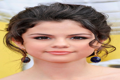

In [145]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = '/content/feminino13.jpg'
image = Image.open(image_path)
image = image.resize((120, 80))
image

In [146]:
image_array = np.array(image) / 255.0
image_array.shape

(80, 120, 3)

In [147]:
image_array = np.expand_dims(image_array, axis=0)

In [148]:
predictions = model.predict(image_array)
predictions
predicted_class = np.argmax(predictions, axis=1)
classes[predicted_class[0]]

1/1 [==============================] - 0s 19ms/step


'female'